In [401]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, signal

In [402]:
def g_tilde(wc, delta, eta, eps, C12, C1, C2, w1, w2):
    g = 0.5 * (wc/(2*delta) * eta - wc/(2*eps) * eta + eta + 1) * C12/(np.sqrt(C1*C2)) * np.sqrt(w1*w2)
    return g

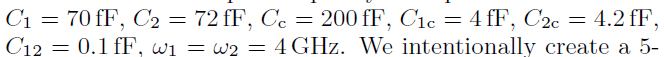

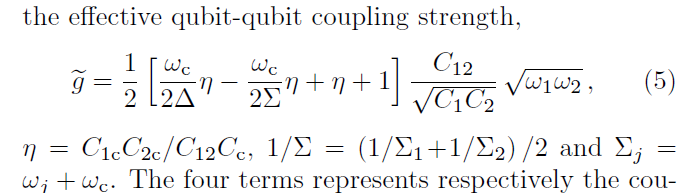

In [403]:
C1 = 70
C2 = 72
Cc = 200
C1c = 4
C2c = 4.2
C12 = 0.1
w1 = 4
w2 = 4
wc = np.linspace(4, 7, 100)
eta = C1c*C2c/(C12*Cc)
eps1 = w1 + wc
eps2 = w2 + wc
eps = ((1/eps1 + 1/eps2)/2)**-1
del1 = w1 - wc
del2 = w2 - wc
delta = ((1/del1 + 1/del2)/2)**-1

C:\Users\leouh\AppData\Local\Temp\ipykernel_2820\662107355.py:16: RuntimeWarning: divide by zero encountered in divide
  delta = ((1/del1 + 1/del2)/2)**-1


In [404]:
g = g_tilde(wc, delta, eta, eps, C12, C1, C2, w1, w2)
g = g * 1e3 # result to MHz

C:\Users\leouh\AppData\Local\Temp\ipykernel_2820\3878555403.py:2: RuntimeWarning: divide by zero encountered in divide
  g = 0.5 * (wc/(2*delta) * eta - wc/(2*eps) * eta + eta + 1) * C12/(np.sqrt(C1*C2)) * np.sqrt(w1*w2)


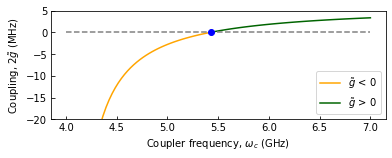

In [405]:
plt.figure(figsize=(6, 2))

zero_index = np.where(g == -np.abs(g).min())
zero_index = zero_index[0][0]

plt.plot(wc[:zero_index], 2*g[:zero_index], 'orange', label=r'$\tilde{g}$ < 0')
plt.plot(wc[zero_index:], 2*g[zero_index:], 'darkgreen', label=r'$\tilde{g}$ > 0')
plt.hlines(0, 4, 7, colors='grey', linestyles='dashed')
plt.plot(wc[zero_index], 0, 'bo')

plt.xlabel(r'Coupler frequency, $\omega_c$ (GHz)')
plt.ylabel(r'Coupling, $2\tilde{g}$ (MHz)')

plt.tick_params(axis='both', direction='in')
plt.ylim(-20, 5)
plt.legend(loc='lower right')

plt.savefig('coupling_vs_wc.jpg', bbox_inches='tight', dpi=300)
plt.show()

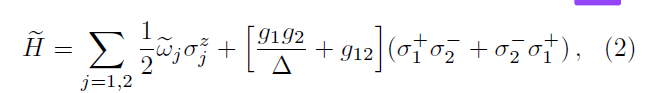

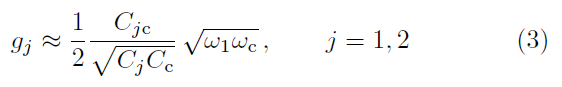

In [406]:
def H(w, g12):
    sigmaz1 = tensor(sigmaz(), qeye(2))
    sigmaz2 = tensor(qeye(2), sigmaz())

    return 1/2 * w[0] * sigmaz1 + 1/2 * w[1] * sigmaz2 + g12 * (tensor(sigmap(), sigmam()) + tensor(sigmam(), sigmap()))

In [407]:
wcs = np.array([wc[27], wc[zero_index], 6])
eps1 = w1 + wcs
eps2 = w2 + wcs
eps = ((1/eps1 + 1/eps2)/2)**-1
del1 = w1 - wcs
del2 = w2 - wcs
delta = ((1/del1 + 1/del2)/2)**-1

g12 = []
Hs = []
i = 0
for w in wcs:
    g12.append(g_tilde(w, delta[i], eta, eps[i], C12, C1, C2, w1, w2)) # * 1e3
    Hs.append(H([w1, w2], g12[i]))
    i += 1

In [408]:
g12

[-0.0024307139779752105, -3.69276767248265e-06, 0.0009240353185031777]

In [409]:
Hs[0]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 4.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.43071398e-03  0.00000000e+00]
 [ 0.00000000e+00 -2.43071398e-03  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.00000000e+00]]

In [419]:
Hs[1]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 4.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -3.69276767e-06  0.00000000e+00]
 [ 0.00000000e+00 -3.69276767e-06  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.00000000e+00]]

In [410]:
def square_pulse(t, args):
    t0 = args['t0']
    width = args['width']
    pulse = np.where((t >= t0 - width / 2) & (t <= t0 + width / 2), 1, 0)
    return pulse

In [411]:
def gauss(t, args): # Gaussian envelope. Sigma is standard deviation
    t0 = args['t0']
    sigma = args['sigma']
    t = np.array(t)
    return 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(t - t0)**2/(2*sigma**2)) # We move the Gaussian peak to t0

def gauss_coef(t, args):
    A = args['A']
    return A * gauss(t, args)

In [412]:
A  = - np.pi / (g12[0]*2) 
A

646.2283678902332

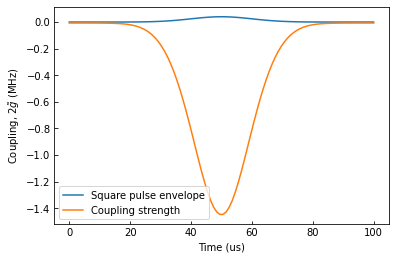

In [413]:
times = np.linspace(0, 100, 100)
plt.plot(times, gauss(times, {'t0': 50, 'sigma': 10, 'A': A}), label='Square pulse envelope')
wcs = wc[zero_index] - gauss_coef(times, {'t0': 50, 'sigma': 10, 'A': A/100})
eps1 = w1 + wcs
eps2 = w2 + wcs
eps = ((1/eps1 + 1/eps2)/2)**-1
del1 = w1 - wcs
del2 = w2 - wcs
delta = ((1/del1 + 1/del2)/2)**-1
g = g_tilde(wcs, delta, eta, eps, C12, C1, C2, w1, w2)
g = g * 1e3 # result to MHz

plt.tick_params(axis='both', direction = 'in')

plt.plot(times, 2*g, label='Coupling strength')
plt.legend()
plt.xlabel(r'Time (us)')
plt.ylabel(r'Coupling, $2\tilde{g}$ (MHz)')
plt.savefig('coupling_vs_time.jpg', bbox_inches='tight', dpi=300)

In [414]:
H = [Hs[1], [Hs[0], gauss_coef]]

In [415]:
init = tensor(basis(2, 1), basis(2, 0))
times = np.linspace(0, 100, 200)
args = {'t0': 50, 'sigma': 10, 'A': A}
sol = mesolve(H, init, times, args=args)

In [416]:
# Helper function to calculate overlap between two states
def prob(solution, t, x):
    return np.abs(solution.states[t].dag() @ x)**2

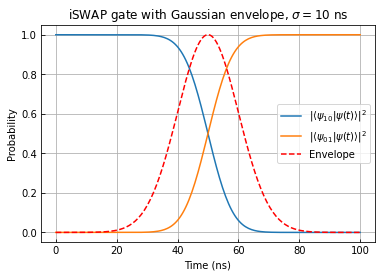

In [417]:
plt.plot(sol.times, [prob(sol, t, init) for t in range(len(sol.times))], label=r'$| \langle \psi_{10} | \psi(t) \rangle |^2$')
plt.plot(sol.times, [prob(sol, t, tensor(basis(2, 0), basis(2, 1))) for t in range(len(sol.times))], label=r'$| \langle \psi_{01} | \psi(t) \rangle |^2$')
plt.plot(sol.times, gauss(sol.times, args)/max(gauss(sol.times, args)), 'r--', label='Envelope')
plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel('Probability')
plt.tick_params(axis='both', direction = 'in')
#sigm = args['sigma']
plt.title(r'iSWAP gate with Gaussian envelope, $\sigma = 10$ ns')
plt.grid()

plt.savefig("iSWAP.jpg", dpi=300)
plt.show()

In [418]:
U = propagator(H, A, args=args, options=Options(nsteps=100000))
U

c:\Users\leouh\AppData\Local\Programs\Python\Python310\lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.32822221+0.89995123j  0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j         -0.00238592+0.j          0.        +0.99999715j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.99999715j -0.00238592+0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.32822221-0.89995123j]]